# Adjoint optimization of a wavelength division multiplexer

In this notebook, we will use a multi-objective optimization to design a wavelength division multiplexer (WDM).

In short, this device takes in broadband light and directs light of different wavelengths to different output ports.

This demo combines the basic setup of our 3rd tutorial of a [mode converter](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin3InverseDesign/) with the multi-frequency objective introduced in our [4th tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin4MultiObjective/).

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).


In [1]:
# first import tidy3d, its adjoint plugin, numpy, and jax.

import tidy3d as td
import tidy3d.plugins.adjoint as tda
import numpy as np
import jax.numpy as jnp
import jax

## Setup

First we set up our basic simulation. 

We have an input waveguide connected to a square design region, which has two output waveguides. 

The square design region is a custom medium with a pixellated permittivity grid that we wish to optimize such that input light of different wavelengths get directed to different output ports.

As this is a SOI device, we typically define the design region and waveguides as Silicon sitting on an SiO2 substrate. For this demo, we make a 2D simulation, but it can be easily made 3D by changing the `Lz` parameter, adding dimension to the structures, and adding a substrate.

In [2]:
# material information
n_si = 3.49
n_sio2 = 1.45 # not used in 2D
n_air = 1

# design output wavelengths
wavelength_top = 1.300
wavelength_bot = 1.550

# and their corresponding frequencies and spectral information
freq_top = td.C_0 / wavelength_top
freq_bot = td.C_0 / wavelength_bot
freq0 = (freq_top + freq_bot) / 2.0
fwidth = abs(freq_bot - freq_top)
run_time = 100 / fwidth

# create dictionaries to reference these later by string key 'top' or 'bot'
freqs = dict(top=freq_top, bot=freq_bot)
wavelengths = dict(top=wavelength_top, bot=wavelength_bot)

# size of design region
lx = 2.8
ly = 2.8
lz = td.inf # in 2D, we say the size of components is inf but the size of simulation is 0.

# size of waveguides
wg_width = 0.3
wg_length = 1.5
wg_spacing = 0.8

# spacing between design region and PML in y
buffer = 1.5

# size of simulation
Lx = lx + wg_length * 2
Ly = ly + buffer * 2
Lz = 0.0

# fabrication constraint (feature size and projection strength)
radius = 0.250
beta = 30

# resolution information
min_steps_per_wvl = 25

In [3]:
# define the waveguide ports

wg_in = td.Structure(
    geometry=td.Box(
        center=(-Lx/2, 0, 0),
        size=(wg_length * 2, wg_width, lz),
    ),
    medium=td.Medium(permittivity=n_si**2)
)

wg_top = td.Structure(
    geometry=td.Box(
        center=(+Lx/2, +wg_width/2+wg_spacing/2, 0),
        size=(wg_length * 2, wg_width, lz),
    ),
    medium=td.Medium(permittivity=n_si**2)
)

wg_bot = td.Structure(
    geometry=td.Box(
        center=(+Lx/2, -wg_width/2-wg_spacing/2, 0),
        size=(wg_length * 2, wg_width, lz),
    ),
    medium=td.Medium(permittivity=n_si**2)
)

# and a field monitor that measures fields on the z=0 plane
fld_mnt = td.FieldMonitor(
    center=(0,0,0),
    size=(td.inf, td.inf, 0),
    freqs=[freq_top, freq_bot],
    name="field",
)

[09:58:45] WARNING: Default value for the field monitor           ]8;id=372012;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=461932;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

> Note we can ignore this warning as it will be resolved after 2.4.0

### Define design region

Here we define the design region as a pixellated grid of permittivity values.

We first define the overall geometry as a `JaxBox` and also the number of pixels in x and y.

In [4]:
nx = 55
ny = 55

design_region_geo = tda.JaxBox(
    size=(lx, ly, lz),
    center=(0,0,0)
)

Next we write a function to give us the pixellated array as a function of our parameters through our filtering and projection methods, which are used to make the resulting structures easier to fabricate. For more details, refer to our 4th lecture in the [inverse design 101 lecture series](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/), which focuses on fabrication constraints.

We also wrap this function in another one that generates the entire `JaxStructure` corresponding to the design region, for convenience later.

In [5]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter

conic_filter = ConicFilter(radius=radius, design_region_dl=lx/nx)

# note: params is an array of shape (nx, ny) that stores values between -inf (air) and +inf (silicon)

def make_eps(params):
    """Make permittivity array as a function of provided parameters."""
    params_filtered = conic_filter.evaluate(params)
    params_01 = 0.5 * (jnp.tanh(beta * params_filtered) + 1)
    params_projected = params_01 * (n_si**2 - 1) + 1.001
    return params_projected

def make_custom_medium(params):
    """Make JaxCustomMedium as a function of provided parameters."""
    eps = make_eps(params).reshape((nx, ny, 1, 1))

    xs = list(jnp.linspace(-lx/2, lx/2, nx))
    ys = list(jnp.linspace(-ly/2, ly/2, ny))
    zs = [0]
    freqs = [freq0]
    coords = dict(x=xs, y=ys, z=zs, f=freqs)

    eps_dataset = tda.JaxDataArray(values=eps, coords=coords)
    
    medium = tda.JaxCustomMedium(
        eps_dataset=tda.JaxPermittivityDataset(
            eps_xx=eps_dataset,
            eps_yy=eps_dataset,
            eps_zz=eps_dataset,
        )
    )

    struct = tda.JaxStructure(
        geometry=design_region_geo,
        medium=medium
    )

    return struct 

### Define base simulation

With all of these functions and variables defined, we can write a single function to return our "base" `JaxSimulation` as a function of our design parameters. This function first constructs the design region and then creates a `JaxSimulation` with all of the basic parameters.

Note, we don't yet have a source or monitors for injecting and measuring our fields, but will add those next after running the mode solver.

In [6]:
def make_sim_base(params):

    input_struct = make_custom_medium(params)
    
    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=wavelength_top),
        structures=[wg_in, wg_top, wg_bot],
        monitors=[fld_mnt],
        input_structures=[input_struct],
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True if Lz else False),
        run_time=run_time,
    )

Let's test out our function. We'll make an initially random array of parameters between (-0.5 and +0.5) and generate the base simulation to plot and inspect.

In [7]:
params0 = (np.random.random((nx, ny)) - 0.5)
sim_base = make_sim_base(params0)

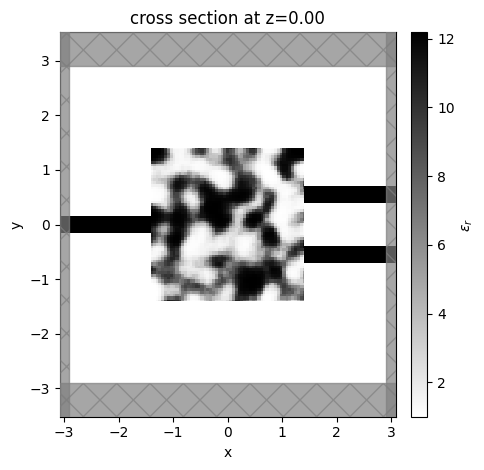

In [8]:
ax = sim_base.plot_eps(z=0, monitor_alpha=0.0)

It all looks good, so now we add the bits that define the optimization.

## Adding Mode Sources and Monitors

### Solving modes
First, we need to create our `ModeSource` and `ModeMonitor` objects that inject and measure the modes that we are interested in optimizing.

We'll use `tidy3d`'s `ModeSolver` and use the remote `run` function that gets more accurate results by running on Flexcompute's servers.

In [9]:
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver

# we'll ask for 4 modes just to inspect
num_modes = 4

# let's define how large the mode planes are and how far they are from the PML relative to the design region
mode_size = (0, 1.8 * wg_spacing + wg_width, max([Lz, lz, 3]))
space_fraction = 0.2

# make a plane corresponding to where we wish to measure the input mode
plane_in = td.Box(
    center=(-Lx/2 + space_fraction * wg_length, 0, 0),
    size=mode_size,
)

# construct the mode solver using our base sim (converted from `JaxSimulation` to regular `Simulation`) + our plane
mode_solver = ModeSolver(
    simulation=sim_base.to_simulation()[0],
    plane=plane_in,
    freqs=[freq_top],
    mode_spec=td.ModeSpec(num_modes=num_modes)
)

Next we run the mode solver on the servers.

In [10]:
mode_data = run_mode_solver(mode_solver)

[09:58:47] Mode solver created with                                    ]8;id=10749;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=243962;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#80\80]8;;\
           task_id='fdve-c1ed101f-1357-4552-9aab-dd55fe766dfav1',               
           solver_id='mo-3eb16275-dbe1-4983-9048-5d6288b2206f'.                 

Output()

Output()

[09:58:50] Mode solver status: queued                                  ]8;id=242317;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=511643;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#93\93]8;;\

[09:58:55] Mode solver status: running                                 ]8;id=669656;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=502446;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#93\93]8;;\

[09:59:10] Mode solver status: success                                ]8;id=771044;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py\web.py]8;;\:]8;id=377446;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/plugins/mode/web.py#103\103]8;;\

Output()

And visualize the results.

Effective index of computed modes:  [[3.1419663 2.806305  1.9542319 1.0627373]]


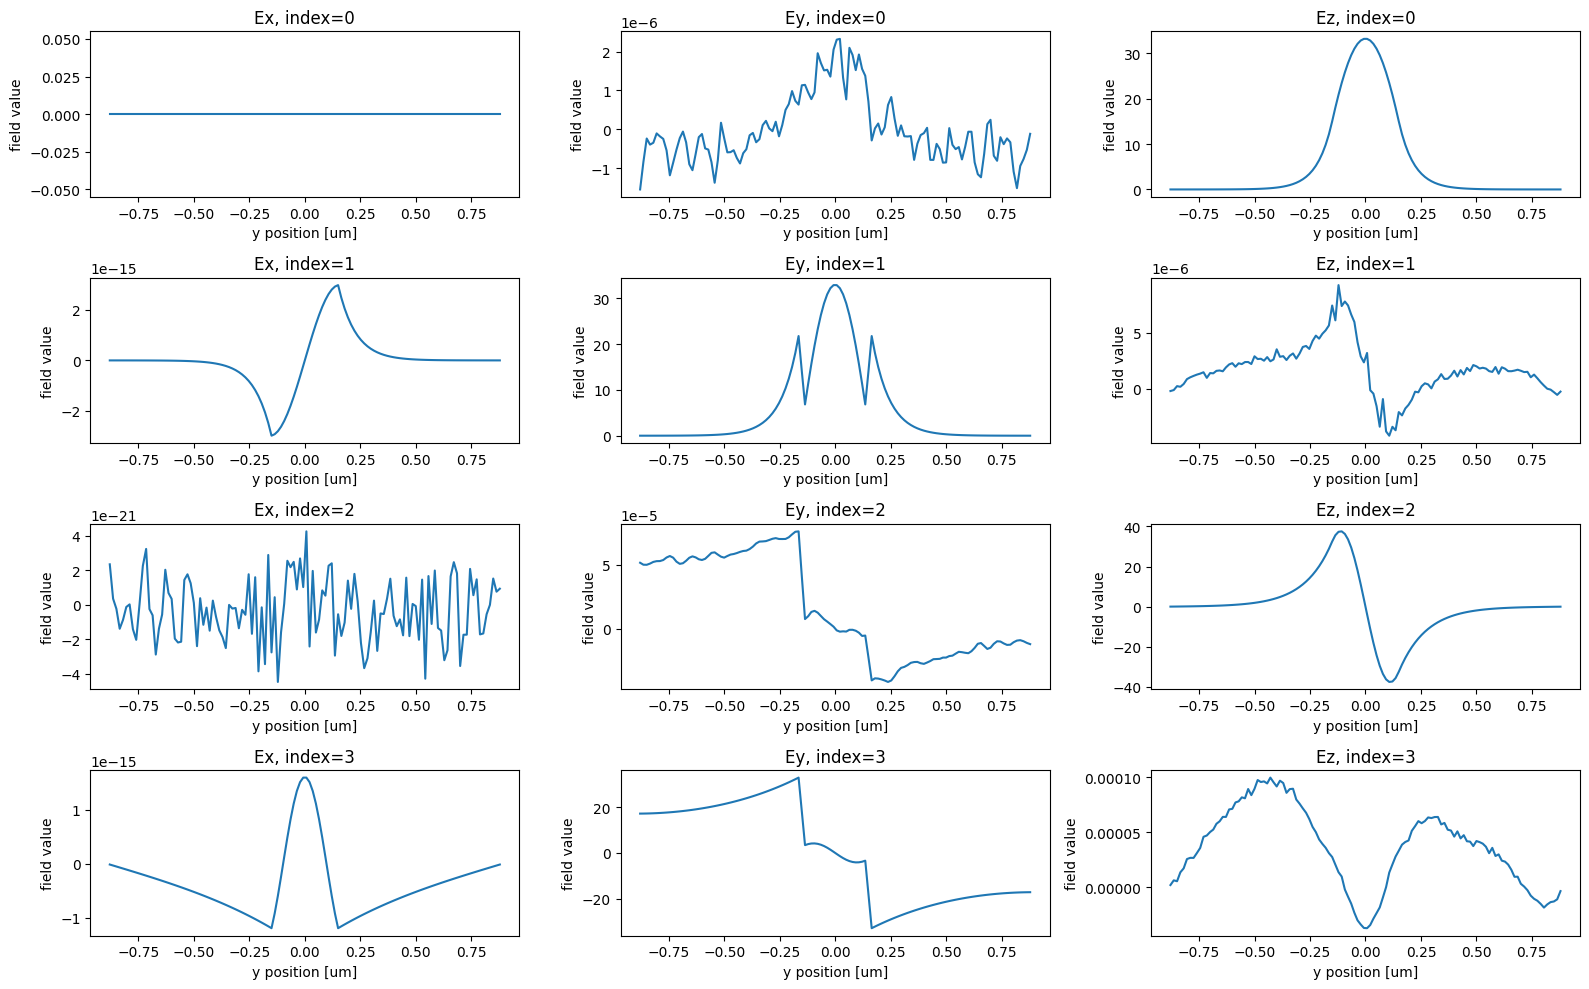

In [11]:
import matplotlib.pyplot as plt
print("Effective index of computed modes: ", jnp.array(mode_data.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(4*num_modes, 10), tight_layout=True)
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(("Ex", "Ey", "Ez")):
        field = mode_data.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(ax=ax)
        ax.set_title(f"{field_name}, index={mode_ind}")

We identify `mode_index=0` as the first order mode that is out of plane of the device. Let's choose to optimize our device with respect to this as the mode of interest for both the input and output.

We re-set the `ModeSpec` to only compute the number of modes we need (1) and also update our `ModeSolver` accordingly.

In [12]:
mode_index = 0
mode_spec = td.ModeSpec(num_modes=mode_index+1)
mode_solver = mode_solver.updated_copy(mode_spec=mode_spec)

### Make input and output mode sources and monitors
Next, we will generate the input `ModeSource` and output `ModeMonitor` objects using the convenience methods defined in the `ModeSolver`.

Because our `plane` was defined at the input port, we'll modify the centers of the `ModeMonitor`s to place them at the output ports to the right of the device.

In [13]:
# make source
mode_src = mode_solver.to_source(
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
    direction="+",
    mode_index=mode_index,
)

# make a basic monitor
mode_mnt = mode_solver.to_monitor(
    freqs=[freq0],
    name="_"
)

# construct the proper centers for the monitors at the 'top' and 'bot' ports
mnt_center_top = list(plane_in.center)
mnt_center_bot = list(plane_in.center)
mnt_center_top[0] = -plane_in.center[0]
mnt_center_bot[0] = -plane_in.center[0]
mnt_center_top[1] = wg_top.geometry.center[1]
mnt_center_bot[1] = wg_bot.geometry.center[1]

# make a dictionary of names and frequencies to refer to later by key
mnt_names = dict(top="mode_top", bot="mode_bot")
mnt_freqs = dict(top=freq_top, bot=freq_bot)

# make two updated copies of the mode monitor with the proper frequencies, centers, and names
mode_mnt_top = mode_mnt.updated_copy(freqs=mnt_freqs["top"], center=mnt_center_top, name=mnt_names["top"])
mode_mnt_bot = mode_mnt.updated_copy(freqs=mnt_freqs["bot"], center=mnt_center_bot, name=mnt_names["bot"])

# make another dictionary mapping the keys to the monitors
mode_mnts = dict(top=mode_mnt_top, bot=mode_mnt_bot)

### Add flux monitors

For plotting later, we'll add a couple of `FluxMonitor` objects at the output ports to measure the total flux over a large spectrum. With this data, we should be able to clearly see the difference in transmission for each of the ports at the design region and get an idea about the device bandwidth.

In [14]:
Nf = 121
freqs_flux = np.linspace(freq_bot - fwidth, freq_top + fwidth, Nf)

flux_mnt_names = dict(top="flux_top", bot="flux_bot")

flux_mnt_top = td.FluxMonitor(
    center=mode_mnt_top.center,
    size=mode_mnt_top.size,
    name=flux_mnt_names["top"],
    freqs=list(freqs_flux),
)

flux_mnt_bot = td.FluxMonitor(
    center=mode_mnt_bot.center,
    size=mode_mnt_bot.size,
    name=flux_mnt_names["bot"],
    freqs=list(freqs_flux),
)


### Add to simulation

Finally, we will wrap our previous `make_sim_base()` function in a new one that adds our new objects to this base simulation given a key `top_or_bot` that can be `"top"` or `"bot"`. Since the `adjoint` plugin can currently only support a single frequency, we need to make a new `JaxSimulation` for each of the `ModeMonitor` outputs. So this function gives us a way to toggle which simulation to generate.

In [15]:
def make_sim(params, top_or_bot: str):

    output_monitor = mode_mnts[top_or_bot]

    sim_base = make_sim_base(params)
    return sim_base.updated_copy(
        output_monitors=[output_monitor],
        sources=[mode_src],
        monitors=tuple(list(sim_base.monitors) + [flux_mnt_top, flux_mnt_bot])
    )

Let's make the two simulations corresponding to `"bot"` and `"top"` and inspect them and ensure it worked as expected.

In [16]:
sim_bot = make_sim(params0, "bot")
sim_top = make_sim(params0, "top")

sims = dict(top=sim_top, bot=sim_bot)

Note: the `FluxMonitor` objects are overlaying the output `ModeMonitor` objects, but we can identify the `ModeMonitor`s by their arrows. We verify that the monitors and sources are in the proper locations and we are ready to move on.

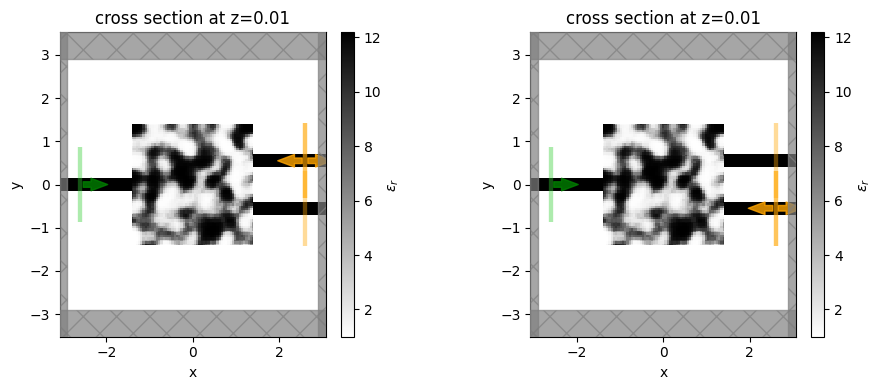

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

ax1 = sim_top.plot_eps(z=0.01, ax=ax1)
ax2 = sim_bot.plot_eps(z=0.01, ax=ax2)

## Defining objective function

With our simulation fully defined as a function of our parameters, we are ready to define our objective function.

### Computing power transmission

In this case, it is quite simple, we simply measure the transmitted power in our output waveguide mode. We wish to maximize transmission to the top port at the "top" wavelength (1330 nm) and maximize transmission to the bottom port at the "bot" wavelength (1550 nm).

We first define a function to measure each of these depending on the `top_or_bot` key.

In [18]:
def measure_power(sim_data, top_or_bot: str):
    mnt_name = mnt_names[top_or_bot]
    mnt_data = sim_data[mnt_name]
    amps = mnt_data.amps
    amp = amps.sel(direction="+", mode_index=0, f=freqs[top_or_bot])
    return jnp.abs(jnp.array(amps.values)) ** 2


### Writing objective function

Then we write an `objective` function that calls this once per key using the `run_asnyc` functionality to do the simulations in parallel over the two frequencies.

> Note, we return the list of `JaxSimulationData` as the second output. The reason for this is that we might wish to access our flux and field data later on. `jax` gives an option `has_aux` to use only the first output for differentiation while letting the user have access to the 2nd "auxiliary" output, which we will make use of.

In [19]:
def objective(params, verbose=False) -> float:
    sim_list = [make_sim(params, top_or_bot) for top_or_bot in ["top", "bot"]]
    sim_data_list = tda.web.run_async(sim_list, path_dir="data", verbose=verbose)
    powers = [measure_power(sim_data, top_or_bot) for sim_data, top_or_bot in zip(sim_data_list, ["top", "bot"])]
    J = jnp.sum(jnp.array(powers)) / len(powers)
    return J, sim_data_list

### Differentiating objective

Finally, we can simply use `jax` to transform this objective function into a function that returns our objective function value, the auxiliary data, and our gradient, which we will feed to the optimizer.

In [20]:
grad_fn = jax.value_and_grad(objective, has_aux=True)

Let's try out our gradient function with verbosity on for just this run.

In [21]:
(J, sim_data_list), grad = grad_fn(params0, verbose=True)

[09:59:15] Created task '0' with task_id                           ]8;id=996799;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=310719;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1'.                       

           View task using web UI at                               ]8;id=404129;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=424385;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=438977;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=649589;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1\taskId]8;;\]8;id=438977;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1\=]8;;\]8;id=745209;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1\fdve]8;;\]8;id=438977;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1\-]8;;\              
           ]8;id=438977;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1\1a501af2-c598-4a98-8d69-9b51a9398b94v1']8;;\.                             

Output()

           Created task '1' with task_id                           ]8;id=567477;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=531569;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1'.                       

           View task using web UI at                               ]8;id=788657;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=422586;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=364447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=802753;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1\taskId]8;;\]8;id=364447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1\=]8;;\]8;id=134520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1\fdve]8;;\]8;id=364447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1\-]8;;\              
           ]8;id=364447;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1\a117e8cf-1b0a-48d4-a453-d260c31431e9v1']8;;\.                             

Output()

Output()

Output()

Output()

Output()

[09:59:24] Started working on Batch.                            ]8;id=202485;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=904064;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[09:59:26] Maximum FlexCredit cost: 0.050 for the whole batch.  ]8;id=356363;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=88674;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[09:59:57] Batch complete.                                      ]8;id=494442;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=744503;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

[09:59:59] loading SimulationData from                             ]8;id=975512;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=910166;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-1a501af2-c598-4a98-8d69-9b51a9398b94v1.hdf5                

Output()

[10:00:01] loading SimulationData from                             ]8;id=814363;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=620352;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-a117e8cf-1b0a-48d4-a453-d260c31431e9v1.hdf5                

           Created task '0' with task_id                           ]8;id=667247;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=34516;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1'.                       

           View task using web UI at                               ]8;id=136740;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=800781;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=55;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=908496;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1\taskId]8;;\]8;id=55;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1\=]8;;\]8;id=41261;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1\fdve]8;;\]8;id=55;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1\-]8;;\              
           ]8;id=55;https://tidy3d.simulation.cloud/workbench?taskId=fdve-90c10d12-2346-4b9f-85bd-c15577c35fa6v1\90c10d12-2346-4b9f-85bd-c15577c35fa6v1']8;;\.                             

Output()

[10:00:02] Created task '1' with task_id                           ]8;id=512090;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=1186;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1'.                       

           View task using web UI at                               ]8;id=65823;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=116795;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=621532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=492848;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1\taskId]8;;\]8;id=621532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1\=]8;;\]8;id=893010;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1\fdve]8;;\]8;id=621532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1\-]8;;\              
           ]8;id=621532;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dad4e892-6737-4ed9-93bc-908951b76c0cv1\dad4e892-6737-4ed9-93bc-908951b76c0cv1']8;;\.                             

Output()

Output()

Output()

Output()

Output()

[10:00:07] Started working on Batch.                            ]8;id=22866;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=284553;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[10:00:08] Maximum FlexCredit cost: 0.050 for the whole batch.  ]8;id=695533;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=55585;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[10:00:29] Batch complete.                                      ]8;id=573557;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=297255;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

Output()

Output()

## Run Opimization

Finally, we are ready to optimize our device. We will make use the `optax` package to define an optimizer using the `adam` method, as we've done in the previous adjoint tutorials.

We record a history of objective function values, simulation data, and parameters for visualization later.

In [22]:
import optax

# hyperparameters
num_steps = 50
learning_rate = 7e-3

# initialize adam optimizer with starting parameters
params = params0
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params0]
data_history = []

for i in range(num_steps):

    # compute gradient and current objective funciton value
    (value, data), gradient = grad_fn(params)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    Js.append(value)
    params_history.append(params)
    data_history.append(data)

step = 1
	J = 5.1920e-02
	grad_norm = 1.0636e+00
step = 2
	J = 2.1518e-02
	grad_norm = 4.4817e-01
step = 3
	J = 4.5617e-02
	grad_norm = 5.8171e-01
step = 4
	J = 1.0428e-01
	grad_norm = 1.2560e+00
step = 5
	J = 2.2467e-01
	grad_norm = 2.0951e+00
step = 6
	J = 4.0407e-01
	grad_norm = 1.9451e+00
step = 7
	J = 4.9980e-01
	grad_norm = 1.7546e+00
step = 8
	J = 5.5494e-01
	grad_norm = 1.5482e+00
step = 9
	J = 5.8666e-01
	grad_norm = 1.5997e+00
step = 10
	J = 6.1590e-01
	grad_norm = 1.6061e+00
step = 11
	J = 6.6412e-01
	grad_norm = 1.5297e+00
step = 12
	J = 7.2633e-01
	grad_norm = 1.0211e+00
step = 13
	J = 7.5046e-01
	grad_norm = 8.8230e-01
step = 14
	J = 7.4023e-01
	grad_norm = 1.1625e+00
step = 15
	J = 7.4828e-01
	grad_norm = 9.9037e-01
step = 16
	J = 7.6213e-01
	grad_norm = 9.8599e-01
step = 17
	J = 7.8019e-01
	grad_norm = 8.4196e-01
step = 18
	J = 7.9737e-01
	grad_norm = 9.6603e-01
step = 19
	J = 8.1405e-01
	grad_norm = 9.6502e-01
step = 20
	J = 8.2894e-01
	grad_norm = 7.4031e-01
step = 21

## Visualize Results

Let's visualize the results of our optimization.

### Objective function vs Iteration

First we inspect the objective function value as a function of optimization iteration number. We see that it steadily increases as expected. 

> The presence of fabrication constraints tends to create some minor bumps in the optimization, which can be a signal that one needs to reduce the step size, but these results are sufficient for our purposes.

Text(0, 0.5, 'objective function')

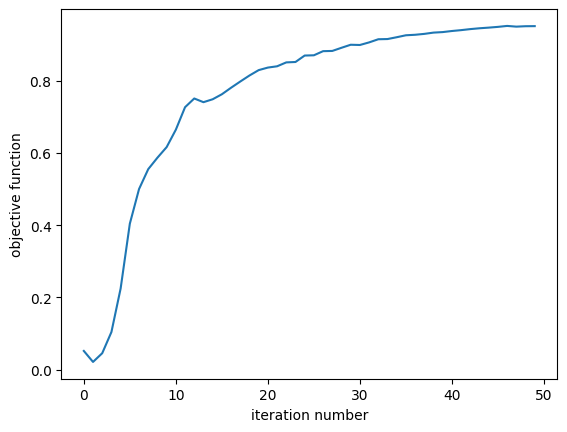

In [23]:
plt.plot(Js)
plt.xlabel('iteration number')
plt.ylabel('objective function')
plt.show()

### Final Simulation

Let's take a look at the final simulation, which we grab from our history.

In [24]:
sim_data_final = data_history[-1][0]
sim_final = sim_data_final.simulation.to_simulation()[0]

We notice that the structure has reasonably large feature sizes but is not well binarized. This could be improved by increasing the `beta` projection value slowly over iteration number, as was done in the [grating coupler tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/).

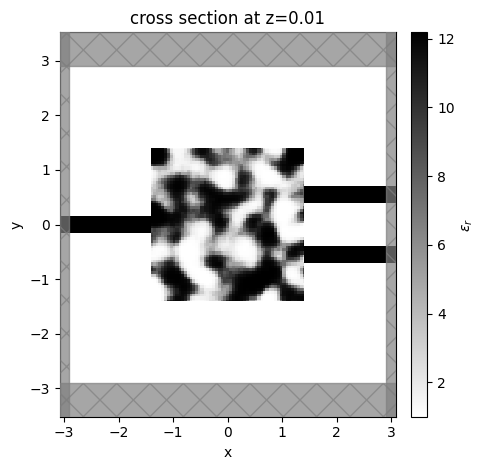

In [59]:
ax = sim_final.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0)

### Flux

Let's inspect the flux over each of the output ports as a function of wavelength.

We notice that the top and bottom ports have peaks in transmission at their corresponding design wavelengths, as expected!

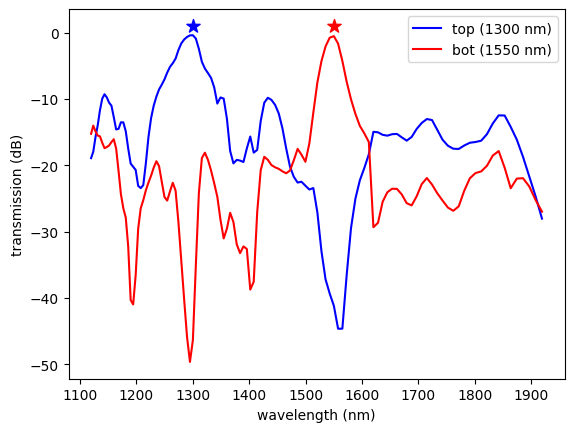

In [38]:
# plot flux
for key, color in zip(("top", "bot"), ('royalblue', 'firebrick')):
    freq = freqs[key]
    flux_data = sim_data_final[flux_mnt_names[key]]
    wvl_nm = 1000 * td.C_0 / freq
    wavelengths_nm = 1000 * td.C_0 / np.array(flux_data.flux.f)
    flux = np.array(flux_data.flux.values)
    flux_db = 10 * np.log(flux)
    label = f"{key} ({int(wvl_nm)} nm)"
    plt.plot(wavelengths_nm, flux_db, label=label, color=color)
    plt.scatter([wvl_nm], [1], 100, marker="*", color=color)
    plt.xlabel('wavelength (nm)')
    plt.ylabel('transmission (dB)')
    plt.legend()

plt.show()

### Fields

Let's also plot the field intensity patterns at the two design wavelengths. We see from this plot the expected result that the power is directed to the design port at each frequency.

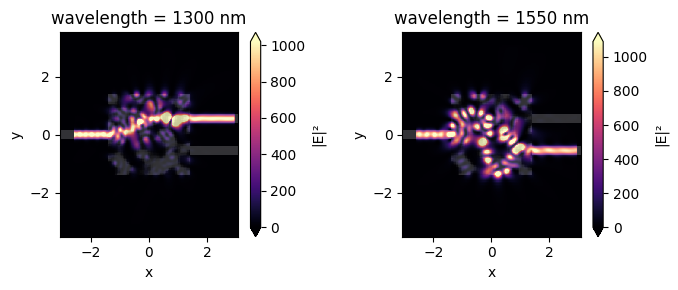

In [42]:
# plot fields at the two design wavelengths

fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(7, 3))

for key, ax in zip(("top", "bot"), axes):
    freq = freqs[key]
    sim_data_final.plot_field("field", "E", "abs^2", f=freq, ax=ax)
    wvl = 1000 * td.C_0 / freq
    ax.set_title(f"wavelength = {int(wvl)} nm")

### Animation

Finally, we animate this plot as a function of iteration number. The animation shows the device quickly accomplishing our design objective.

> Note: can take a few minutes to complete

In [66]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, (ax1, ax2, ax3) = fig, axes = plt.subplots(1, 3, tight_layout=False, figsize=(9, 4))

def animate(i):

    sim_data_list_i = data_history[i]

    sim_i = sim_data_list_i[0].simulation.to_simulation()[0]
    sim_i.plot_eps(z=0.01, monitor_alpha=0, source_alpha=0, ax=ax1)
    ax1.set_aspect('equal')

    for key, ax, sim_data_i in zip(("top", "bot"), (ax2, ax3), sim_data_list_i):

        freq = freqs[key]
        wvl = 1000 * td.C_0 / freq

        int_i = sim_data_i.get_intensity("field").sel(f=freq)
        int_i.squeeze().plot.pcolormesh(x='x', y='y', ax=ax, add_colorbar=False, cmap="magma", vmax=1000)
        
        ax.set_aspect('equal')
        ax.set_title(f"wavelength = {int(wvl)} nm")
    
# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(data_history))
plt.close()

# display the animation (press "play" to start)
_ = HTML(ani.to_jshtml())


<Figure size 640x480 with 0 Axes>

To save the animation as a file, uncomment the line below

> Note: can take several more minutes to complete

In [67]:
# ani.save('img/animation_wdm_adjoint.gif', fps=60)

MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>